In [ ]:
!pip install transformers==3.1.0

     |████████████████████████████████| 884 kB 9.6 MB/s 
     |████████████████████████████████| 1.2 MB 52.3 MB/s 
     |████████████████████████████████| 895 kB 60.2 MB/s 
     |████████████████████████████████| 3.0 MB 44.2 MB/s 


In [ ]:
!pip install contractions

     |████████████████████████████████| 284 kB 9.2 MB/s 
     |████████████████████████████████| 106 kB 17.5 MB/s 


In [ ]:
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip"

--2022-02-27 11:49:50--  https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42989872 (41M) [application/x-httpd-php]
Saving to: ‘drugsCom_raw.zip’

drugsCom_raw.zip    100%[===================>]  41.00M  68.1MB/s    in 0.6s    

2022-02-27 11:49:50 (68.1 MB/s) - ‘drugsCom_raw.zip’ saved [42989872/42989872]



In [ ]:
!unzip "drugsCom_raw.zip"

Archive:  drugsCom_raw.zip
  inflating: drugsComTest_raw.tsv    
  inflating: drugsComTrain_raw.tsv   


In [ ]:
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification

import tensorflow as tf
import pandas as pd

In [ ]:
import numpy as np
import pandas as pd

df = pd.read_table('drugsComTrain_raw.tsv')
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [ ]:
top_10_conditions = df['condition'].value_counts().head(10).index.tolist()
top_10_conditions

['Birth Control',
 'Depression',
 'Pain',
 'Anxiety',
 'Acne',
 'Bipolar Disorde',
 'Insomnia',
 'Weight Loss',
 'Obesity',
 'ADHD']

In [ ]:
# df['condition'] = df['condition'].apply(lambda x: x if x in ['Birth Control'] else 'OTHERS')
# df['condition'].value_counts().plot(kind='bar')

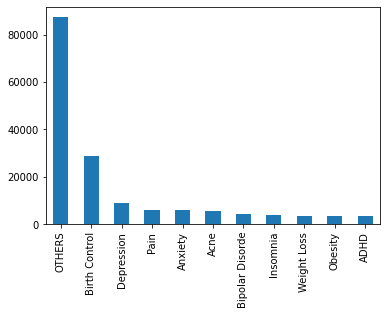

In [ ]:
df['condition'] = df['condition'].apply(lambda x: x if x in top_10_conditions else 'OTHERS')
df['condition'].value_counts().plot(kind='bar')

In [ ]:
import re
import html
import contractions

def remove_chars(text):
    text = html.unescape(text)
    text = contractions.fix(text)
    # remove_chars = r'&amp;|\u200b|\x7f|\x11'
    remove_chars_1 = r'[^A-Za-z0-9 ]'
    remove_chars_2 = r'^"'
    remove_chars_3 = r'"$'
    more_than_two_spaces = r'[\s\s]+'
    # text = re.sub(remove_chars, ' ', text)
    # text = re.sub(remove_chars, ' ', text)
    text = re.sub(remove_chars_1, ' ', text)
    text = re.sub(remove_chars_2, ' ', text)
    text = re.sub(remove_chars_3, ' ', text)
    text = re.sub(more_than_two_spaces, ' ', text)
    return text.lower().strip()


df['cleaned_text'] = df['review'].apply(remove_chars)

In [ ]:
#### Import and prepare data

In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

X = df['cleaned_text'][:10000]
y = df['condition'][:10000]

le = preprocessing.LabelEncoder()
labels = le.fit_transform(y)
y = list(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [ ]:
training_sentences = X_train.tolist()
training_labels = y_train

validation_sentences = X_test.tolist()
validation_labels = y_test

In [ ]:
# from sklearn import preprocessing

# training_size = 8000

# sentences = df['review'][:10000].tolist()
# labels = df['condition'][:10000].tolist()

# le = preprocessing.LabelEncoder()
# labels = le.fit_transform(labels)
# labels = list(labels)

# training_sentences = sentences[0:training_size]
# validation_sentences = sentences[training_size:]
# training_labels = labels[0:training_size]
# validation_labels = labels[training_size:]

In [ ]:
len(set(training_labels))

11

In [ ]:
print(len(training_sentences))
print(len(validation_sentences))

6700
3300


In [ ]:
#### Setup BERT and run training

# https://huggingface.co/transformers/pretrained_models.html
# distilbert-base-multilingual-cased

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
train_encodings = tokenizer(training_sentences,
                            truncation=True,
                            padding=True)
val_encodings = tokenizer(validation_sentences,
                            truncation=True,
                            padding=True)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    training_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    validation_labels
))

In [ ]:
# We classify two labels in this example. In case of multiclass classification, adjust num_labels value
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=11)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_79', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.fit(train_dataset.shuffle(100).batch(16),
          epochs=3,
          batch_size=16,
          validation_data=val_dataset.shuffle(100).batch(16))

Epoch 1/3
419/419 [==============================] - 438s 1s/step - loss: 3.0273 - accuracy: 0.2704 - val_loss: 2.3979 - val_accuracy: 0.0358
Epoch 2/3
 67/419 [===>..........................] - ETA: 5:17 - loss: 2.3979 - accuracy: 0.0410

In [ ]:
model.save_pretrained("/tmp/model")

In [ ]:
#### Load saved model and run predict function

In [ ]:
loaded_model = TFDistilBertForSequenceClassification.from_pretrained("/tmp/model")

Some weights of the model checkpoint at /tmp/sentiment_custom_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /tmp/sentiment_custom_model and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
